In [1]:
%matplotlib inline

import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.model_selection import train_test_split
from itertools import product
import collections
import math
import random
import matplotlib.pyplot as plt
import numpy as np

from utils import ModelTrainer
from datasets import avGFPDataset, GB1Dataset, SGEMMDataset, EntacmaeaDataset

In [2]:
class FCN(nn.Module):
    def __init__(self, n, multiplier=2, batch_norm=False):
        super(FCN, self).__init__()
        self.fc1 = nn.Linear(n, multiplier*n)
        self.fc2 = nn.Linear(multiplier*n, multiplier*n)
        self.fc3 = nn.Linear(multiplier*n, n)
        self.fc4 = nn.Linear(n, 1)

        torch.nn.init.xavier_uniform_(self.fc1.weight)
        torch.nn.init.xavier_uniform_(self.fc2.weight)
        torch.nn.init.xavier_uniform_(self.fc3.weight)
        torch.nn.init.xavier_uniform_(self.fc4.weight)
        
        self.batch_norm = batch_norm
        if self.batch_norm:
            self.bn1 = nn.BatchNorm1d(multiplier*n)
            self.bn2 = nn.BatchNorm1d(multiplier*n)
            self.bn3 = nn.BatchNorm1d(n)

    def forward(self, x):
        if self.batch_norm:
            x = self.bn1(F.leaky_relu(self.fc1(x)))
            x = self.bn2(F.leaky_relu(self.fc2(x)))
            x = self.bn3(F.leaky_relu(self.fc3(x)))
            x = self.fc4(x)
        else:
            x = F.leaky_relu(self.fc1(x))
            x = F.leaky_relu(self.fc2(x))
            x = F.leaky_relu(self.fc3(x))
            x = self.fc4(x)

        return x.reshape(-1)

Loaded dataset from cache.
#0 - Train Loss: 1.010, R2: -0.030	Validation Loss: 0.738, R2: 0.262	alternate_loss: 0.35432
#1 - Train Loss: 0.346, R2: 0.647	Validation Loss: 0.597, R2: 0.403	alternate_loss: 26.92513
#2 - Train Loss: 0.160, R2: 0.836	Validation Loss: 0.560, R2: 0.440	alternate_loss: 63.74999
#3 - Train Loss: 0.084, R2: 0.914	Validation Loss: 0.567, R2: 0.433	alternate_loss: 81.53207
#4 - Train Loss: 0.086, R2: 0.913	Validation Loss: 0.567, R2: 0.433	alternate_loss: 26.59999
#5 - Train Loss: 0.043, R2: 0.956	Validation Loss: 0.553, R2: 0.447	alternate_loss: 52.38102
#6 - Train Loss: 0.026, R2: 0.973	Validation Loss: 0.550, R2: 0.450	alternate_loss: 38.72058
#7 - Train Loss: 0.015, R2: 0.984	Validation Loss: 0.537, R2: 0.463	alternate_loss: 28.45723
#8 - Train Loss: 0.016, R2: 0.984	Validation Loss: 0.538, R2: 0.462	alternate_loss: 26.60867
#9 - Train Loss: 0.009, R2: 0.990	Validation Loss: 0.546, R2: 0.454	alternate_loss: 28.58626
#10 - Train Loss: 0.009, R2: 0.991	Validati

#88 - Train Loss: 0.004, R2: 0.996	Validation Loss: 0.627, R2: 0.373	alternate_loss: 18.63190
#89 - Train Loss: 0.004, R2: 0.996	Validation Loss: 0.585, R2: 0.415	alternate_loss: 19.66565
#90 - Train Loss: 0.004, R2: 0.996	Validation Loss: 0.626, R2: 0.374	alternate_loss: 16.70835
#91 - Train Loss: 0.004, R2: 0.996	Validation Loss: 0.594, R2: 0.406	alternate_loss: 22.90574
#92 - Train Loss: 0.003, R2: 0.997	Validation Loss: 0.606, R2: 0.394	alternate_loss: 19.45034
#93 - Train Loss: 0.003, R2: 0.997	Validation Loss: 0.596, R2: 0.404	alternate_loss: 20.67950
#94 - Train Loss: 0.003, R2: 0.997	Validation Loss: 0.593, R2: 0.407	alternate_loss: 18.90625
#95 - Train Loss: 0.003, R2: 0.997	Validation Loss: 0.590, R2: 0.410	alternate_loss: 17.08685
#96 - Train Loss: 0.003, R2: 0.997	Validation Loss: 0.608, R2: 0.392	alternate_loss: 16.43115
#97 - Train Loss: 0.002, R2: 0.998	Validation Loss: 0.597, R2: 0.403	alternate_loss: 15.47952
#98 - Train Loss: 0.002, R2: 0.998	Validation Loss: 0.587, R

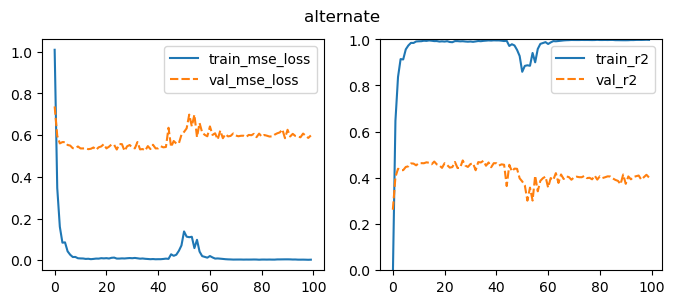

In [4]:
fix_seed = 1
random_seed = 11
dataset = "avGFP"

train_size = 500

config = {
    "training_method": "hashing",
    "b": 10,
    "lr": 0.01, 
    "weight_decay": 0, 
    "hadamard_lambda": 0.0001,
    "num_epochs": 100,
    "random_seed": random_seed,
    "fix_seed": fix_seed,
    "train_size": train_size,
    "dataset": dataset,
    "batch_size": 16,
    "normalize": True,
}

# config = {
#     "training_method": "normal",
#     "lr": 0.001, 
#     "weight_decay": 0, 
#     "num_epochs": 100,
#     "random_seed": random_seed,
#     "fix_seed": fix_seed,
#     "train_size": train_size,
#     "batch_size": 16,
#     "dataset": dataset,
#     "normalize": True
# }

# config = {
#     "training_method": "EN-S",
#     "SPRIGHT_d": 3,
#     "rho": 0.01,
#     "b": 7,
#     "lr": 0.01, 
#     "weight_decay": 0, 
#     "hadamard_lambda": 1,
#     "num_epochs": 100,
#     "random_seed": random_seed,
#     "fix_seed": fix_seed,
#     "train_size": train_size,
#     "batch_size": 16,
#     "dataset": dataset,
#     "normalize": True
# }

config = {
    "training_method": "alternate",
    "b": 5,
    "lr": 0.01, 
    "SPRIGHT_d": 3,
    "weight_decay": 0, 
    "hadamard_lambda": 0.01,
    "num_epochs": 100,
    "random_seed": random_seed,
    "fix_seed": fix_seed,
    "train_size": train_size,
    "dataset": dataset,
    "batch_size": 16,
    "normalize": True,
    "whole_train": True,
}

    
# Dataset
torch.manual_seed(config["fix_seed"])
if dataset == "GB1":
    dataset = GB1Dataset()
elif dataset == "avGFP":
    dataset = avGFPDataset()
elif dataset == "SGEMM":
    dataset = SGEMMDataset()
elif dataset == "Entacmaea":
    dataset = EntacmaeaDataset()
else:
    raise Exception
    
if config.get("normalize", False):
    dataset.y = (dataset.y-torch.mean(dataset.y))/torch.std(dataset.y)
dataset_size = len(dataset)
train_ds, val_ds = torch.utils.data.random_split(dataset, [config["train_size"], dataset_size - config["train_size"]])

# Train model
torch.manual_seed(config["random_seed"]) # Seed for network initialization
in_dim = dataset.X.shape[1]
model = FCN(in_dim, 1, batch_norm=False)
trainer = ModelTrainer(model, train_ds, val_ds, config=config,  plot_results=True, checkpoint_cache=True)
model = trainer.train_model()
print(max([l["val_r2"] for l in trainer.logs]))


In [6]:
dataset.X.shape

torch.Size([241600, 34])

In [29]:
loss = nn.L1Loss(reduction='sum')
input = torch.randn(3, 5, requires_grad=True)
target = torch.randn(3, 5)
output = loss(input, target)
output.backward()

In [30]:
output

tensor(19.1421, grad_fn=<L1LossBackward0>)

In [31]:
input

tensor([[ 0.5268, -1.8115,  0.7159,  0.0330,  0.0356],
        [-2.3874, -2.3935,  0.8949,  0.3207,  0.9698],
        [ 1.3622, -0.4997,  0.5467, -1.2911, -0.7537]], requires_grad=True)

In [32]:
torch.abs(input - target)

tensor([[1.4174, 2.2973, 1.6245, 0.0703, 0.6259],
        [0.0172, 2.8585, 1.0336, 2.5225, 1.3419],
        [1.1301, 1.0042, 1.4258, 0.6240, 1.1490]], grad_fn=<AbsBackward0>)

In [34]:
torch.sum(torch.abs(input - target), axis=1)

tensor([6.0355, 7.7736, 5.3330], grad_fn=<SumBackward1>)